In [1]:
#Initial Setup
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as MSE
from time import process_time

In [3]:
df = pd.read_csv('dass_modeling.csv')
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,4,2,4,4,4,4,4,2,1,...,2,1,2,No Degree,27,3,34,4,40,4
1,4,1,2,3,4,4,3,4,3,2,...,2,1,4,No Degree,24,3,17,3,27,3
2,3,1,4,1,4,3,1,3,2,4,...,1,1,3,No Degree,39,4,12,2,17,1
3,2,3,2,1,3,3,4,2,3,3,...,2,1,5,Biology,16,2,17,3,16,1
4,2,2,3,4,4,2,4,4,4,3,...,2,1,4,Psychology,32,4,40,4,29,3


In [4]:
#df.drop('age_group',axis=1,inplace=True)

In [5]:
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,4,2,4,4,4,4,4,2,1,...,2,1,2,No Degree,27,3,34,4,40,4
1,4,1,2,3,4,4,3,4,3,2,...,2,1,4,No Degree,24,3,17,3,27,3
2,3,1,4,1,4,3,1,3,2,4,...,1,1,3,No Degree,39,4,12,2,17,1
3,2,3,2,1,3,3,4,2,3,3,...,2,1,5,Biology,16,2,17,3,16,1
4,2,2,3,4,4,2,4,4,4,3,...,2,1,4,Psychology,32,4,40,4,29,3


In [6]:
df.dtypes.value_counts()

int64     63
object     2
dtype: int64

In [7]:
df['country']=pd.factorize(df['country'], sort=True)[0]+1
df['major']=pd.factorize(df['major'], sort=True)[0]+1
df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,4,2,4,4,4,4,4,2,1,...,2,1,2,46,27,3,34,4,40,4
1,4,1,2,3,4,4,3,4,3,2,...,2,1,4,46,24,3,17,3,27,3
2,3,1,4,1,4,3,1,3,2,4,...,1,1,3,46,39,4,12,2,17,1
3,2,3,2,1,3,3,4,2,3,3,...,2,1,5,10,16,2,17,3,16,1
4,2,2,3,4,4,2,4,4,4,3,...,2,1,4,56,32,4,40,4,29,3


In [8]:
df.dtypes.value_counts()

int64    65
dtype: int64

In [15]:
# Target variable will determine severe depression. Levels 3 or 4 indicates severe depression.  So 1 means the individual has 
# severe depression, while 0 means they do not.

bin_out=[]

for i in df['Depression_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)

df['Depression_cat_bin']=bin_out

# Repeat same for Anxiety
bin_out=[]

for i in df['Anxiety_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)

df['Anxiety_cat_bin']=bin_out

# ...and for Stress
bin_out=[]

for i in df['Stress_cat']:
    if i > 2:
        bin_out.append(1)
    else:
        bin_out.append(0)

df['Stress_cat_bin']=bin_out

df.head()

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat,Depression_cat_bin,Anxiety_cat_bin,Stress_cat_bin
0,4,4,2,4,4,4,4,4,2,1,...,46,27,3,34,4,40,4,1,1,1
1,4,1,2,3,4,4,3,4,3,2,...,46,24,3,17,3,27,3,1,1,1
2,3,1,4,1,4,3,1,3,2,4,...,46,39,4,12,2,17,1,1,0,0
3,2,3,2,1,3,3,4,2,3,3,...,10,16,2,17,3,16,1,0,1,0
4,2,2,3,4,4,2,4,4,4,3,...,56,32,4,40,4,29,3,1,1,1


In [33]:
df.drop(['Depression', 'Depression_cat', 'Anxiety', 'Anxiety_cat', 'Stress', 'Stress_cat'],axis=1,inplace=True)

In [34]:
df

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,religion,orientation,race,voted,married,familysize,major,Depression_cat_bin,Anxiety_cat_bin,Stress_cat_bin
0,4,4,2,4,4,4,4,4,2,1,...,12,1,10,2,1,2,46,1,1,1
1,4,1,2,3,4,4,3,4,3,2,...,7,0,70,2,1,4,46,1,1,1
2,3,1,4,1,4,3,1,3,2,4,...,4,3,60,1,1,3,46,1,0,0
3,2,3,2,1,3,3,4,2,3,3,...,4,5,70,2,1,5,10,0,1,0
4,2,2,3,4,4,2,4,4,4,3,...,10,1,10,2,1,4,56,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39732,2,1,3,2,3,2,1,3,1,4,...,2,4,60,2,1,2,46,1,0,0
39733,3,4,3,4,3,4,4,4,3,4,...,10,0,10,2,1,4,42,1,1,1
39734,2,1,2,1,1,1,1,1,2,1,...,7,1,30,1,2,3,32,0,0,0
39735,3,1,2,2,3,3,3,4,3,1,...,6,1,60,1,1,2,42,0,0,1


In [9]:
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

In [36]:
# Slice feature columns from dataframe for X
X = df.iloc[:,:59]
y = df['Depression_cat_bin']

       Q1A  Q2A  Q3A  Q4A  Q5A  Q6A  Q7A  Q8A  Q9A  Q10A  ...  screensize  \
0        4    4    2    4    4    4    4    4    2     1  ...           1   
1        4    1    2    3    4    4    3    4    3     2  ...           2   
2        3    1    4    1    4    3    1    3    2     4  ...           2   
3        2    3    2    1    3    3    4    2    3     3  ...           2   
4        2    2    3    4    4    2    4    4    4     3  ...           2   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...         ...   
39732    2    1    3    2    3    2    1    3    1     4  ...           2   
39733    3    4    3    4    3    4    4    4    3     4  ...           1   
39734    2    1    2    1    1    1    1    1    2     1  ...           2   
39735    3    1    2    2    3    3    3    4    3     1  ...           2   
39736    2    1    2    1    4    2    1    1    1     1  ...           1   

       uniquenetworklocation  hand  religion  orientation  race  voted  \
0

# create pipeline
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
model = RandomForestRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])
# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

In [37]:
# Apply MinMaxScaler for PCA
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)

In [38]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(X_rescaled)
reduced_ninety_five = pca.transform(X_rescaled)
no_comp = reduced_ninety_five.shape[1]
no_comp

46

This shows that 46 components will capture 95% of the variance.

ValueError: x and y must have same first dimension, but have shapes (17,) and (59,)

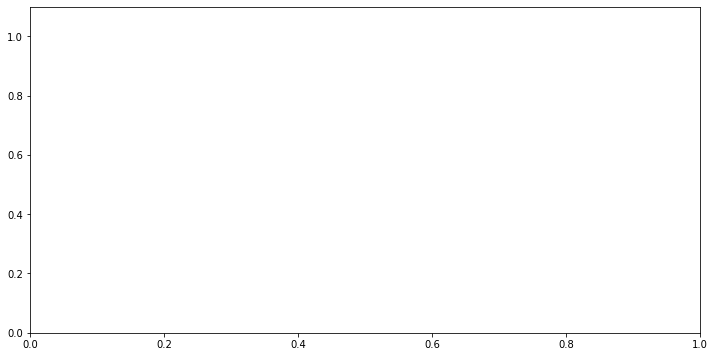

In [40]:
# Visualizing the PCA determination of number of components

pca = PCA().fit(X_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 18, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 18, step=1)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [16]:
# Three different output columns to examine
y = df['Depression_cat_bin']

# Check balance of dataset
y.value_counts()

1    20039
0    19698
Name: Depression_cat_bin, dtype: int64

The data looks very well-balanced, so I may not need to perform SMOTE-ENN after all.  To be thorough, I'll examine the value counts before and after SMOTE-ENN.

In [17]:
# Perform SMOTE-ENN on the dataset
resample=SMOTEENN(random_state=42)

X_res, y_res = resample.fit_resample(X,y)

print(y_res.value_counts())

0    16521
1    16369
Name: Depression_cat_bin, dtype: int64


In [18]:
# Create training and test sets to examine DEPRESSION
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [30]:
# Apply Principal Component Analysis
pca = PCA(n_components = no_comp)
X_train = pca.fit_transform(X_train_scaled)
X_test = pca.transform(X_test_scaled)
X_train = pd.DataFrame(X_train)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.245699,2.044810,-0.011465,1.680536,1.296783,-0.324737,1.099666,-1.255611,-0.135130,1.281283,-0.319733,0.109865,0.368694,-0.299893,-0.355077
1,3.645541,-0.449333,-0.855909,-0.799180,-0.507379,-0.324282,-0.502384,0.223359,-0.560529,-0.111149,0.585425,0.608119,0.351462,-0.360344,0.585656
2,2.651433,-0.557994,0.397640,0.342033,-0.376482,0.458132,-0.227679,1.395856,0.276544,-0.405715,0.108002,-0.555170,-0.108515,0.117006,-0.256500
3,-1.243101,0.898592,2.586675,0.116360,-0.765235,-0.147448,-1.707307,-0.647496,-2.161600,0.135606,0.146265,0.100758,-0.160252,-0.609430,0.611448
4,2.680019,2.596735,-0.276913,0.308714,-0.394475,0.523243,0.678814,-0.055002,-1.520908,-0.364465,0.121636,0.911075,1.206149,0.228430,1.666953


In [20]:
# Examine feature importance
dtc=DecisionTreeClassifier()
dtc.fit(X_train,y_train)

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': dtc.feature_importances_})

importances = importances.sort_values(by='Importance', ascending=False)

print(importances)

    Attribute  Importance
0           0    0.822844
1           1    0.152958
2           2    0.010123
14         14    0.002239
6           6    0.002094
9           9    0.001574
12         12    0.001557
4           4    0.001465
11         11    0.000958
10         10    0.000803
5           5    0.000758
8           8    0.000749
7           7    0.000743
3           3    0.000726
13         13    0.000410


In [21]:
# Perform Recursive Feature Elimination to get a ranked list
regressor = RandomForestRegressor(n_estimators=100, max_depth=10)
n_features_to_select = 1
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestRegressor(max_depth=10), n_features_to_select=1)

In [22]:
from operator import itemgetter
features = X_train.columns.to_list()
for x, y in (sorted(zip(rfe.ranking_ , features), key=itemgetter(0))):
    print(x, y)

1 0
2 1
3 2
4 9
5 12
6 11
7 6
8 3
9 14
10 5
11 4
12 13
13 10
14 7
15 8


In [23]:
n_features_to_select = 10
rfe = RFE(regressor, n_features_to_select=n_features_to_select)
rfe.fit(X_train, y_train)

RFE(estimator=RandomForestRegressor(max_depth=10), n_features_to_select=10)

In [27]:
predictions = rfe.predict(X_test)
predictions

array([9.98545102e-01, 5.16668281e-05, 9.99476647e-01, ...,
       1.09303716e-04, 1.24355779e-01, 5.16668281e-05])

In [28]:
output = pd.DataFrame({"Id":X_test.index, target:predictions})
output

AttributeError: 'numpy.ndarray' object has no attribute 'index'

t1_start = process_time() 

rfc = RandomForestRegressor(random_state=42)
rfc.fit(X_train_scaled,y_train)
y_pred=rfc.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

In [31]:
# Create a training and test sets for post-SMOTE-ENN data to examine DEPRESSION
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
t1_start = process_time() 

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_scaled,y_train)
y_pred=rfc.predict(X_test_scaled)
RMSE = MSE(y_test, y_pred)**0.5
print('RMSE = ',RMSE)

t1_stop = process_time()

print ('Processing time = ', t1_stop - t1_start)

NameError: name 'RandomForestClassifier' is not defined

In [ ]:
# Compute 5-fold cross-validation scores=
cv_scores = cross_val_score(rfc, X, y, cv=5)
print("5-Fold CV Scores: ", cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

In [ ]:
ay = df['Anxiety_cat']
sy = df['Stress_cat']